In [27]:
import datetime
import logging
import os
import numpy as np
import matplotlib.pyplot as plt
import random
## Only when developing with VSCode in my repo 
#os.chdir('/home/nicolas/codeRepo/OceanPlatformControl') # here in Azure
os.chdir('/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl') # here in WSL
print(os.getcwd())
##
import pandas as pd
from ocean_navigation_simulator.reinforcement_learning.missions.CachedNavigationProblem import (
    CachedNavigationProblem,
)
from ocean_navigation_simulator.utils.misc import set_arena_loggers
from ocean_navigation_simulator.utils.units import Distance
# These lines in VSCode to avoid reloading the kernel when changes are made to the external kernel
%load_ext autoreload
%autoreload 2
# Settings for where the problem csv is saved
# my_path = os.getcwd()
# results_folder = os.path.join(my_path, "tmp/missions/")
# os.makedirs(results_folder, exist_ok=True)

/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path_to_files = 'generated_media/metrics_csv_results/'
pb_name_hj_naive = 'problemsGOMmetrics_hj_naive.csv'
pb_name_reactive = 'problemsGOMmetrics_reactive.csv'
pb_name_flocking = 'problemsGOMmetrics_flocking.csv'

In [12]:
metrics_hj_naive = pd.read_csv(f"{path_to_files}/{pb_name_hj_naive}")
#problem_hj_reactive = pd.read_csv(f"{path_to_files}/{pb_name_reactive}")
metrics_flocking = pd.read_csv(f"{path_to_files}/{pb_name_flocking}")

In [8]:
metrics_hj_naive

,Isolated_platform_metric,Number_of_collision,Reaching_target,Mean minimum distance to target among all platforms in deg,Mean maximum correction from optimal control degrees,Average Beta Index,Initial maximum degree of the graph,Final maximum degree of the graph,Mission_sucess
0,0,0,1.00,0.000000,0,1.242545,2,3,1
1,0,0,0.00,0.073967,0,1.104537,2,3,0
2,45800,0,1.00,0.000000,0,1.010638,2,3,0
3,0,0,1.00,0.000000,0,1.252546,2,3,1
4,0,0,1.00,0.000000,0,1.385510,3,3,1
5,259500,0,1.00,0.000000,0,0.812057,2,3,0
6,0,1,1.00,0.000000,0,1.333178,3,3,0
7,175200,0,1.00,0.000000,0,0.762559,2,3,0
8,130200,0,0.25,0.021353,0,0.849909,2,3,0
9,0,0,1.00,0.000000,0,1.500000,3,3,1


In [33]:
metrics_summary_hj_naive = {
    "avg_beta_index":np.mean(metrics_hj_naive["Average Beta Index"]),
    "avg_isolated_pltf_integral_hj_naive": np.mean(metrics_hj_naive["Isolated_platform_metric"]),
    "avg_correction_from_opt_ctrl_deg": np.mean(metrics_hj_naive["Mean maximum correction from optimal control degrees"]),
    "avg_mean_min_dist_to_target_km": Distance(deg=np.mean(metrics_hj_naive["Mean minimum distance to target among all platforms in deg"])).km,
    "nb_missions_with_isolated_pltf": np.sum(metrics_hj_naive["Isolated_platform_metric"] > 0),
    "nb_missions_with_collisions": np.sum(metrics_hj_naive["Number_of_collision"] > 0),
    "nb_missions_success": np.sum(metrics_hj_naive["Mission_sucess"]==1),
}
print(metrics_summary_hj_naive)

{'avg_beta_index': 1.061275035767803, 'avg_isolated_pltf_integral_hj_naive': 97363.33333333333, 'avg_correction_from_opt_ctrl_deg': 0.0, 'avg_mean_min_dist_to_target_km': 0.6022088646782777, 'nb_missions_with_isolated_pltf': 13, 'nb_missions_with_collisions': 3, 'nb_missions_success': 12}


In [34]:
metrics_summary_flocking = {
    "avg_beta_index":np.mean(metrics_flocking["Average Beta Index"]),
    "avg_isolated_pltf_integral_hj_naive": np.mean(metrics_flocking["Isolated_platform_metric"]),
    "avg_correction_from_opt_ctrl_deg": np.mean(metrics_flocking["Mean maximum correction from optimal control degrees"]),
    "avg_mean_min_dist_to_target_km": Distance(deg=np.mean(metrics_flocking["Mean minimum distance to target among all platforms in deg"])).km,
    "nb_missions_with_isolated_pltf": np.sum(metrics_flocking["Isolated_platform_metric"] > 0),
    "nb_missions_with_collisions": np.sum(metrics_flocking["Number_of_collision"] > 0),
    "nb_missions_success": np.sum(metrics_flocking["Mission_sucess"]==1),
}
print(metrics_summary_flocking)

{'avg_beta_index': 1.3732038733493388, 'avg_isolated_pltf_integral_hj_naive': 4186.666666666667, 'avg_correction_from_opt_ctrl_deg': 24.322445525956223, 'avg_mean_min_dist_to_target_km': 0.6979519567421218, 'nb_missions_with_isolated_pltf': 3, 'nb_missions_with_collisions': 0, 'nb_missions_success': 18}


In [35]:
def plot_confusion_matrix(x, y, x_label, y_label):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm

    confusion_matrix = pd.crosstab(x, y, rownames=[x_label], colnames=[y_label])

    ax = sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.RdYlGn, square=True, norm=LogNorm(), fmt='g')
    plt.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=True, labeltop=True)
    ax.xaxis.set_label_position('top')
    plt.show()

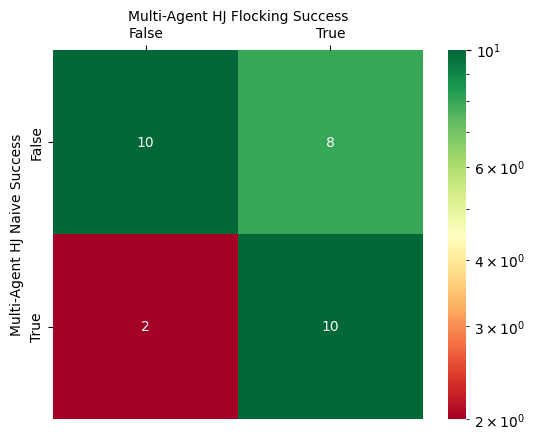

In [37]:
plot_confusion_matrix(metrics_hj_naive["Mission_sucess"]==1, metrics_flocking["Mission_sucess"]==1, 'Multi-Agent HJ Naive Success', 'Multi-Agent HJ Flocking Success')

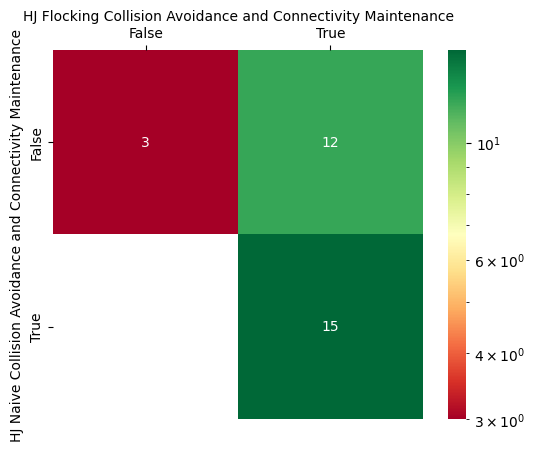

In [41]:
connect_objective_flocking = (metrics_flocking["Isolated_platform_metric"]==0) & (metrics_flocking["Number_of_collision"] == 0)
connect_objective_hj_naive = (metrics_hj_naive["Isolated_platform_metric"]==0) & (metrics_hj_naive["Number_of_collision"] == 0)
plot_confusion_matrix(connect_objective_hj_naive , connect_objective_flocking , 'HJ Naive Collision Avoidance and Connectivity Maintenance', 'HJ Flocking Collision Avoidance and Connectivity Maintenance')